In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pydicom as dcm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm_notebook
warnings.filterwarnings('ignore')

In [2]:
output_path = "/kaggle/working"
PATH = "/kaggle/input/rsna-pneumonia-detection-challenge"

In [3]:
# make sure output directories exist
image_output_dir = os.path.join(output_path, 'images')
os.makedirs(image_output_dir, exist_ok=True)

In [4]:
# Set matplotlib for inline display
%matplotlib inline

# LOAD AND EXPLORE DATASET STRUCTURE

In [5]:
# images in training set
image_train_path = os.path.join(PATH, 'stage_2_train_images')
if os.path.exists(image_train_path):
    train_images = os.listdir(image_train_path)
    print(f"Number of images in train set: {len(train_images)}")
else:
    print("Training images directory not found!")

Number of images in train set: 26684


### EXPLORE CLASS INFORMATION DATASET

In [6]:
# Load class information dataset
class_info_df = pd.read_csv(os.path.join(PATH, 'stage_2_detailed_class_info.csv'))
print(f"Class Information Dataset Shape: {class_info_df.shape}")
print("\nFirst 5 samples of class_info_df:")
print(class_info_df.head())

Class Information Dataset Shape: (30227, 2)

First 5 samples of class_info_df:
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


In [7]:
def plot_class_distribution(df, output_dir, filename='class_distribution.png', dpi=300):
    """Plots and saves the class distribution as a horizontal countplot."""
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(y='class', data=df, palette='viridis', ax=ax)
    ax.set_title('Class Distribution', fontsize=16)
    ax.set_xlabel('Count', fontsize=12)
    ax.set_ylabel('Class', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    fig.tight_layout()

    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved Class Distribution to {save_path}")

    plt.show()
    plt.close(fig)

Saved Class Distribution to /kaggle/working/images/class_distribution.png


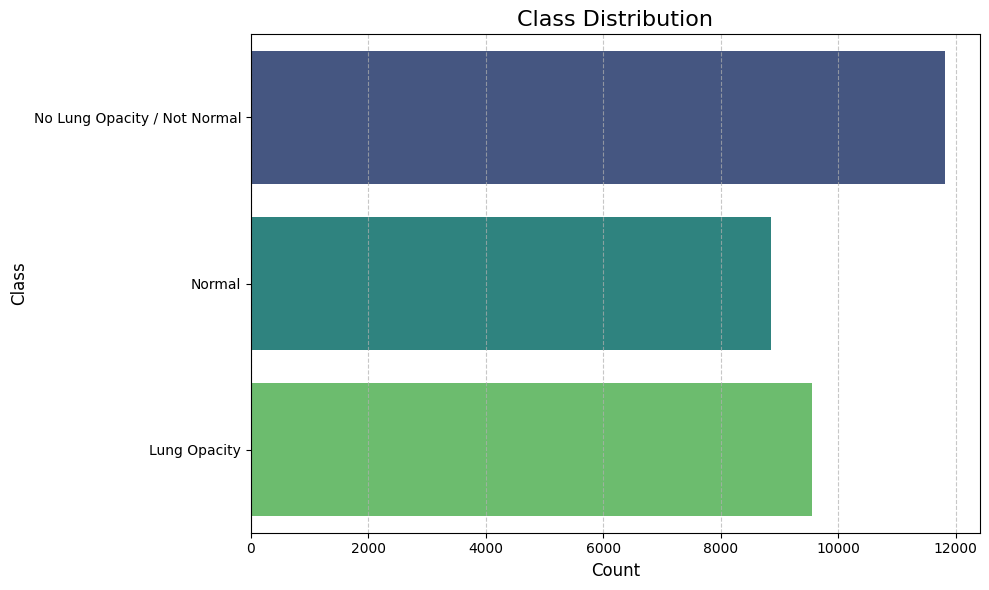

In [8]:
plot_class_distribution(class_info_df, image_output_dir)

In [9]:
# Check for missing values
print("\nMissing Values in Class Information Dataset:")
print(class_info_df.isna().sum())


Missing Values in Class Information Dataset:
patientId    0
class        0
dtype: int64


### EXPLORE TRAIN LABELS DATASET

In [10]:
# Load train labels dataset
train_labels_df = pd.read_csv(os.path.join(PATH, 'stage_2_train_labels.csv'))
print(f"Train Labels Dataset Shape: {train_labels_df.shape}")
print("\nFirst 5 samples of train_labels_df:")
print(train_labels_df.head())

Train Labels Dataset Shape: (30227, 6)

First 5 samples of train_labels_df:
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [11]:
def plot_target_distribution(df, output_dir, filename='target_distribution.png', dpi=300):
    """Plots and saves the target distribution."""
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.countplot(x='Target', data=df, palette=['skyblue', 'salmon'], ax=ax)
    ax.set_title('Target Distribution', fontsize=16)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No Pneumonia', 'Pneumonia'], fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()

    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved Target Distribution to {save_path}")

    plt.show()
    plt.close(fig)

Saved Target Distribution to /kaggle/working/images/target_distribution.png


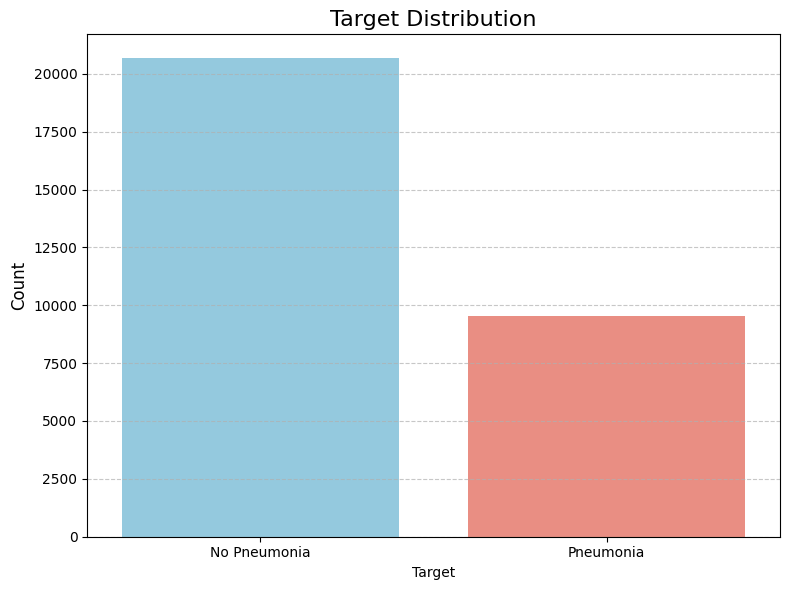

In [12]:
plot_target_distribution(train_labels_df, image_output_dir)

In [13]:
# Check for unique patient IDs
patient_counts = train_labels_df['patientId'].nunique()
print(f"\nNumber of unique patients: {patient_counts}")


Number of unique patients: 26684


In [14]:
# Check for missing values
print("\nMissing Values in Train Labels Dataset:")
print(train_labels_df.isna().sum())


Missing Values in Train Labels Dataset:
patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
dtype: int64


In [15]:
# Check for bounding box statistics - only for positive cases
bbox_data = train_labels_df[train_labels_df['Target'] == 1][['x', 'y', 'width', 'height']]
bbox_data.sample(3)

,x,y,width,height
27119,254.0,393.0,207.0,206.0
1504,209.0,538.0,194.0,242.0
19226,580.0,271.0,285.0,472.0


In [16]:
def plot_width_height_distribution(bbox_data, output_dir, 
                    wh_filename='bbox_width_height.png',
                    area_filename='bbox_area_distribution.png',
                    dpi=300):
    """
    Plots & saves:
      1) Width & height distributions side by side
      2) Area distribution
    """
    if bbox_data.empty:
        print("No bounding‐box data to plot.")
        return

    # --- Width & Height ---
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.histplot(bbox_data['width'], kde=True, ax=axes[0], color='blue')
    axes[0].set_title('Bounding Box Width Distribution', fontsize=14)
    axes[0].set_xlabel('Width', fontsize=12)
    axes[0].grid(linestyle='--', alpha=0.7)

    sns.histplot(bbox_data['height'], kde=True, ax=axes[1], color='green')
    axes[1].set_title('Bounding Box Height Distribution', fontsize=14)
    axes[1].set_xlabel('Height', fontsize=12)
    axes[1].grid(linestyle='--', alpha=0.7)

    fig.tight_layout()
    wh_path = os.path.join(output_dir, wh_filename)
    fig.savefig(wh_path, dpi=dpi)
    print(f"Saved Width/Height distribution to   {wh_path}")
    plt.show()
    plt.close(fig)

    # --- Area ---
    df_area = bbox_data.copy()
    df_area['area'] = df_area['width'] * df_area['height']

    fig2, ax2 = plt.subplots(figsize=(10, 6))
    sns.histplot(df_area['area'], kde=True, ax=ax2, color='purple')
    ax2.set_title('Bounding Box Area Distribution', fontsize=16)
    ax2.set_xlabel('Area (width × height)', fontsize=12)
    ax2.grid(linestyle='--', alpha=0.7)

    fig2.tight_layout()
    area_path = os.path.join(output_dir, area_filename)
    fig2.savefig(area_path, dpi=dpi)
    print(f"Saved Area distribution to   {area_path}")
    plt.show()
    plt.close(fig2)

Saved Width/Height distribution to   /kaggle/working/images/bbox_width_height.png


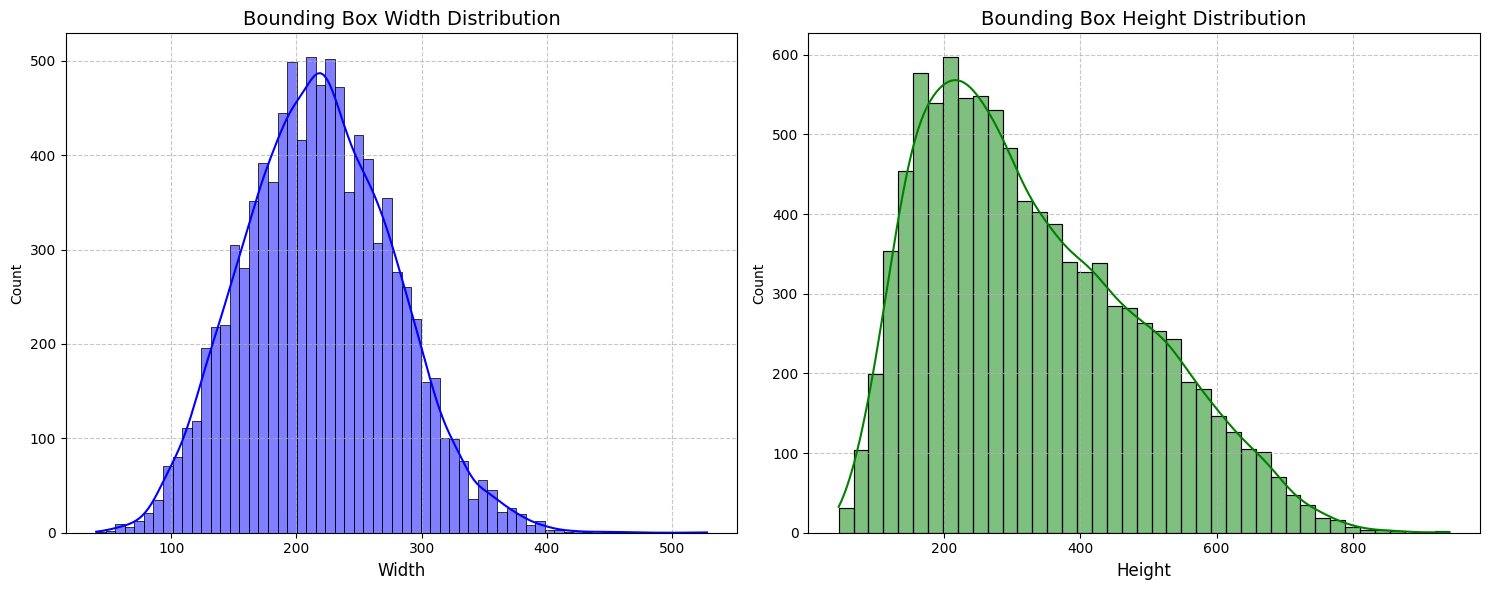

Saved Area distribution to   /kaggle/working/images/bbox_area_distribution.png


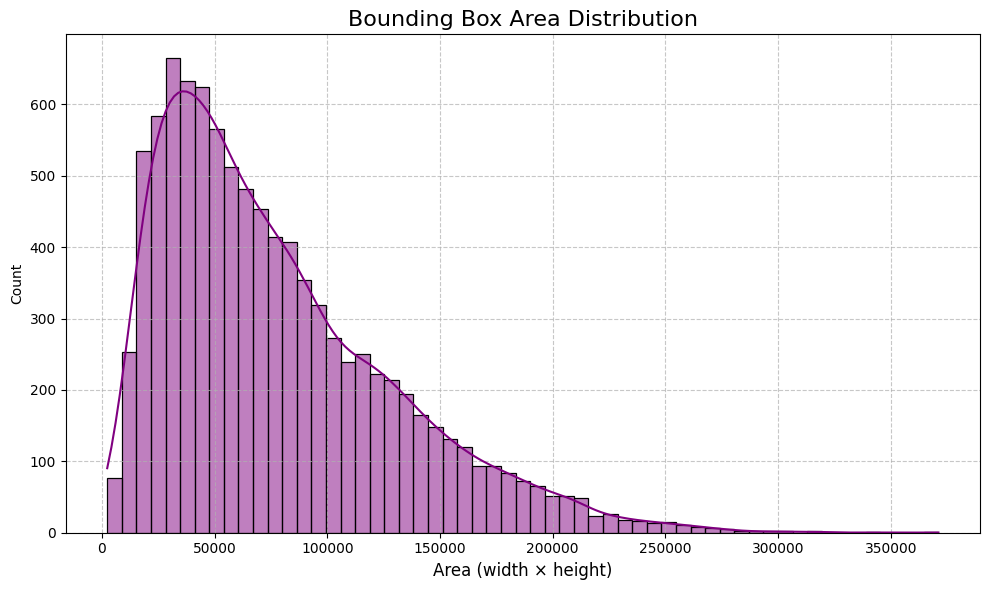

In [17]:
plot_width_height_distribution(bbox_data, image_output_dir)

### MERGE DATASETS & ANALYZE COMBINED DATA

In [18]:
# Merge the two datasets
train_class_df = pd.merge(train_labels_df, class_info_df, on='patientId')
train_class_df = train_class_df.drop_duplicates()
print(f"Combined Dataset Shape: {train_class_df.shape}")
print("\nFirst 5 samples of merged dataset:")
train_class_df.head()

Combined Dataset Shape: (30227, 7)

First 5 samples of merged dataset:


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [19]:
train_class_df['class'].value_counts()

class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64

#### Target distribution by class

In [20]:
def plot_target_by_class_distribution(df, output_dir,
                                      filename='target_by_class_distribution.png',
                                      dpi=300):
    """
    Plots & saves the target distribution within each class.
    Expects df with columns 'class' and 'Target'.
    """

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.countplot(x='class', hue='Target', data=df,
                  palette=['skyblue', 'salmon'], ax=ax)
    ax.set_title('Target Distribution by Class', fontsize=16)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='Target', labels=['No Pneumonia', 'Pneumonia'])
    ax.tick_params(axis='x', labelsize=10, rotation=0)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    fig.tight_layout()
    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved Target-by-Class Distribution to {save_path}")

    plt.show()
    plt.close(fig)

Saved Target-by-Class Distribution to /kaggle/working/images/target_by_class_distribution.png


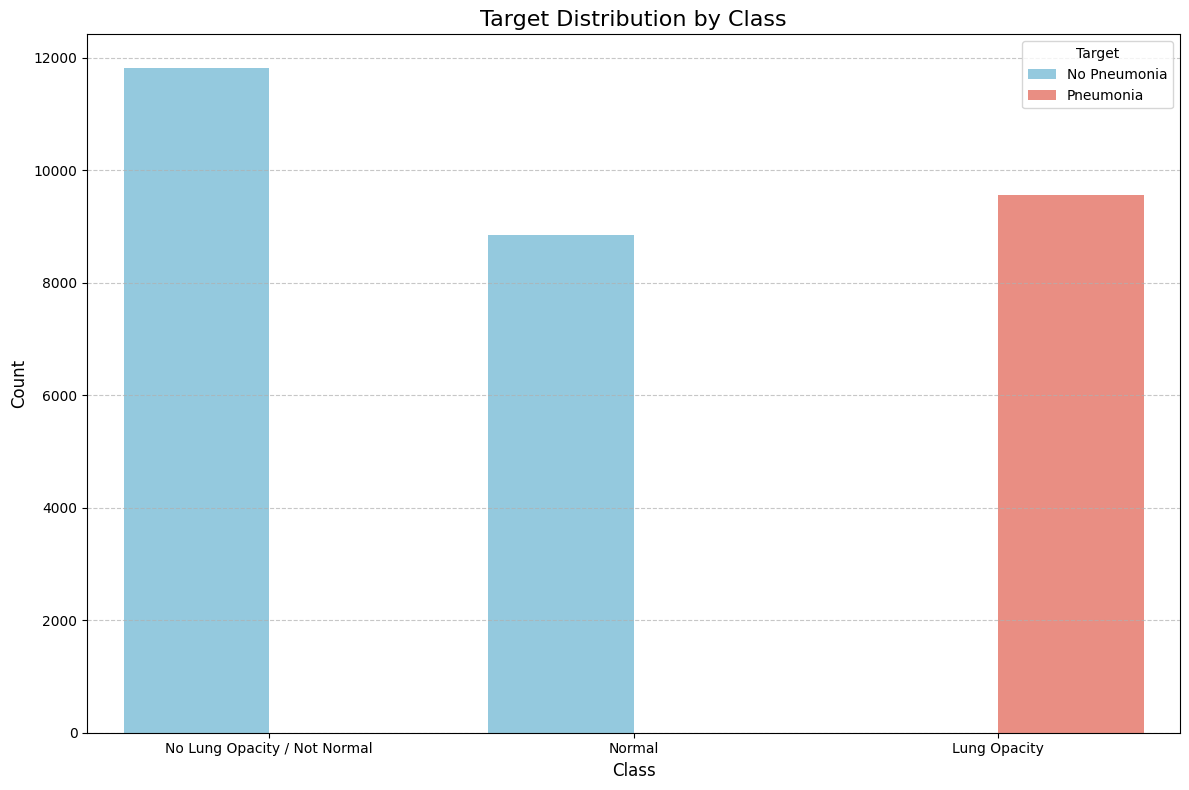

In [21]:
plot_target_by_class_distribution(train_class_df, image_output_dir)

### PROCESS DICOM METADATA

In [22]:
# Process DICOM metadata (first, let's grab a sample to explore the available metadata)
sample_id = train_class_df.sample(1)['patientId'].values[0]
sample_id_path = sample_id + '.dcm'
dicom_file_path = os.path.join(PATH, "stage_2_train_images", sample_id_path)

In [23]:
try:
    dicom_file_dataset = dcm.dcmread(dicom_file_path)
    print("Sample DICOM metadata:")
    for elem in dicom_file_dataset:
        if elem.VR != 'OW' and elem.VR != 'OB':  # Skip binary data elements
            print(f"{elem.name}: {elem.value}")
except Exception as e:
    print(f"Error reading DICOM file: {e}")

Sample DICOM metadata:
Specific Character Set: ISO_IR 100
SOP Class UID: 1.2.840.10008.5.1.4.1.1.7
SOP Instance UID: 1.2.276.0.7230010.3.1.4.8323329.18630.1517874412.691159
Study Date: 19010101
Study Time: 000000.00
Accession Number: 
Modality: CR
Conversion Type: WSD
Referring Physician's Name: 
Series Description: view: AP
Patient's Name: d0eddd98-9377-475a-94d8-6c9663fa8396
Patient ID: d0eddd98-9377-475a-94d8-6c9663fa8396
Patient's Birth Date: 
Patient's Sex: F
Patient's Age: 32
Body Part Examined: CHEST
View Position: AP
Study Instance UID: 1.2.276.0.7230010.3.1.2.8323329.18630.1517874412.691158
Series Instance UID: 1.2.276.0.7230010.3.1.3.8323329.18630.1517874412.691157
Study ID: 
Series Number: 1
Instance Number: 1
Patient Orientation: 
Samples per Pixel: 1
Photometric Interpretation: MONOCHROME2
Rows: 1024
Columns: 1024
Pixel Spacing: [0.168, 0.168]
Bits Allocated: 8
Bits Stored: 8
High Bit: 7
Pixel Representation: 0
Lossy Image Compression: 01
Lossy Image Compression Method: IS

In [24]:
def process_dicom_data(data_df, data_path, base_path=''):
    """
    Process DICOM files and extract metadata.
    
    Parameters:
    - data_df: DataFrame containing patientId
    - data_path: path to DICOM files relative to base_path
    - base_path: root directory
    
    Returns:
    - DataFrame with added DICOM metadata
    """
    vars_to_add = [
        'Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined',
        'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing',
    ]
    
    # Create a copy to avoid in-place modification
    df = data_df.copy()
    
    # Add columns if they don't already exist
    for var in vars_to_add:
        if var not in df.columns:
            df[var] = None

    image_paths = os.listdir(os.path.join(base_path, data_path))
    
    print(f"Processing {len(image_paths)} DICOM files...")
    
    for img_name in tqdm(image_paths, desc="Processing DICOM files"):
        image_path = os.path.join(base_path, data_path, img_name)
        try:
            dicom_data = dcm.dcmread(image_path)
            patient_id = dicom_data.PatientID
            idx = df['patientId'] == patient_id

            df.loc[idx, 'Modality'] = getattr(dicom_data, 'Modality', None)
            
            # Convert PatientAge to numeric, handling 'XXXY' format
            pat_age = getattr(dicom_data, 'PatientAge', None)
            if pat_age is not None:
                if isinstance(pat_age, str) and 'Y' in pat_age:
                    pat_age = pat_age.replace('Y', '')
                df.loc[idx, 'PatientAge'] = pd.to_numeric(pat_age, errors='coerce')
            
            df.loc[idx, 'PatientSex'] = getattr(dicom_data, 'PatientSex', None)
            df.loc[idx, 'BodyPartExamined'] = getattr(dicom_data, 'BodyPartExamined', None)
            df.loc[idx, 'ViewPosition'] = getattr(dicom_data, 'ViewPosition', None)
            df.loc[idx, 'ConversionType'] = getattr(dicom_data, 'ConversionType', None)
            df.loc[idx, 'Rows'] = getattr(dicom_data, 'Rows', None)
            df.loc[idx, 'Columns'] = getattr(dicom_data, 'Columns', None)
            
            # Handle pixel spacing
            pixel_spacing = getattr(dicom_data, 'PixelSpacing', [None])
            if pixel_spacing is not None and len(pixel_spacing) > 0 and pixel_spacing[0] is not None:
                df.loc[idx, 'PixelSpacing'] = f"{float(pixel_spacing[0]):.3f}"
            
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

    return df

In [25]:
# Process DICOM data (with optional sampling for faster execution)
try:
    # Sample size can be adjusted based on computational resources
    # Use None instead of a number to process all files
    train_class_df_with_dicom = process_dicom_data(
        data_df=train_class_df, # use small sample for validating the data 
        data_path='stage_2_train_images',
        base_path=PATH)
    
    print("\nDICOM Metadata Processed Successfully!")
    print(f"Updated DataFrame shape: {train_class_df_with_dicom.shape}")
    
except Exception as e:
    print(f"Error in DICOM processing: {e}")
    print("Continuing with analysis without complete DICOM metadata...")

Processing 26684 DICOM files...


Processing DICOM files: 100%|██████████| 26684/26684 [08:26<00:00, 52.66it/s]


DICOM Metadata Processed Successfully!
Updated DataFrame shape: (30227, 16)


### METADATA DISTRIBUTION ANALYSIS

In [26]:
train_class_df = train_class_df_with_dicom.copy()

In [27]:
train_class_df.sample()

,patientId,x,y,width,height,Target,class,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
3938,346b381b-02fb-40da-82fa-cb2760a71a5b,NaN,NaN,NaN,NaN,0,Normal,CR,51,M,CHEST,PA,WSD,1024,1024,0.171


In [28]:
train_class_df = train_class_df[train_class_df['class'].isin(['Lung Opacity', 'Normal'])]

In [29]:
n_per_class = 3000

In [30]:
tmp1 = train_class_df[train_class_df['class']=='Lung Opacity'].sample(n_per_class, random_state=42)
tmp1.shape

(3000, 16)

In [31]:
tmp2 = train_class_df[train_class_df['class']=='Normal'].sample(n_per_class, random_state=42)
tmp2.shape

(3000, 16)

In [32]:
train_class_df = pd.concat([tmp1, tmp2.sample(tmp1.shape[0])])
train_class_df.shape

(6000, 16)

In [35]:
train_class_df.PatientAge

6298     75
36395    40
1694     48
18809    47
12197    43
         ..
23654    39
5606     64
12430    69
29397    39
31528    57
Name: PatientAge, Length: 6000, dtype: object

In [47]:
bins = [0, 19, 30, 50, float('inf')]
labels = [
    '0-19',
    '20-30',
    '31-50',
    '51+'
]

In [48]:
# Create the binned age category column
train_class_df['AgeCategory'] = pd.cut(train_class_df['PatientAge'], bins=bins, labels=labels, right=True, include_lowest=True)

# Count the number of patients in each category
age_counts = train_class_df['AgeCategory'].value_counts().sort_index()


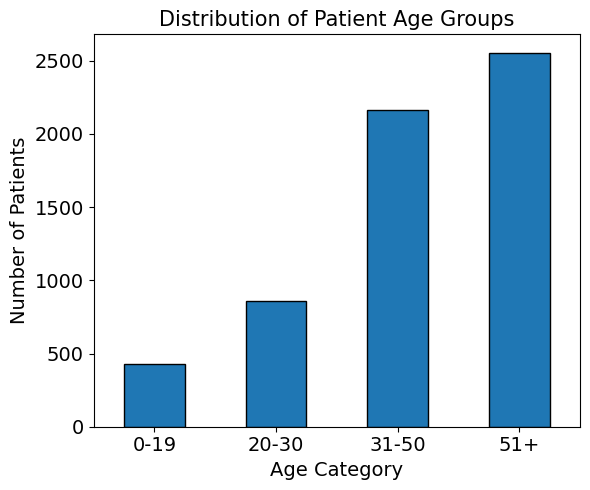

In [51]:
# Plot the distribution as a bar chart
plt.figure(figsize=(6, 5))
age_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Age Category', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.title('Distribution of Patient Age Groups', fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("Distribution_of_Patient_Age_Groups.png", dpi=300)
plt.show()

In [ ]:
train_class_df.to_csv('train_class_df.csv', index=False)

In [ ]:
# Check for missing values in the metadata
print("\nMissing Values in DICOM Metadata:")
metadata_cols = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined',
                'ViewPosition', 'Rows', 'Columns', 'PixelSpacing']
print(train_class_df[metadata_cols].isna().sum())

In [ ]:
def plot_patient_sex_distribution(df, output_dir,
                                  filename='patient_sex_distribution.png',
                                  dpi=300):
    """
    Prints counts of 'PatientSex' and plots & saves its distribution.
    Expects df to have a 'PatientSex' column.
    """
    if 'PatientSex' not in df.columns:
        print("Column 'PatientSex' not found in DataFrame.")
        return

    # Print counts
    print("\nPatient Sex Distribution:")
    sex_counts = df['PatientSex'].value_counts()
    print(sex_counts)

    # Plot & save
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(x='PatientSex', data=df, ax=ax)
    ax.set_title('Patient Sex Distribution', fontsize=16)
    ax.set_xlabel('Sex', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()

    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved Patient Sex Distribution to {save_path}")

    plt.show()
    plt.close(fig)

In [ ]:
plot_patient_sex_distribution(train_class_df, image_output_dir)

In [ ]:
def plot_patient_age_distribution(df, output_dir,
                                  filename='patient_age_distribution.png',
                                  dpi=300, bins=20):
    """
    Prints descriptive stats for 'PatientAge' and plots & saves its distribution.
    Expects df to have a 'PatientAge' column.
    """
    if 'PatientAge' not in df.columns:
        print("Column 'PatientAge' not found in DataFrame.")
        return

    # Print statistics
    print("\nPatient Age Distribution:")
    age_stats = df['PatientAge'].describe()
    print(age_stats)

    # Plot & save
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(df['PatientAge'].dropna(), kde=True, bins=bins, ax=ax)
    ax.set_title('Patient Age Distribution', fontsize=16)
    ax.set_xlabel('Age', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.grid(linestyle='--', alpha=0.7)
    fig.tight_layout()

    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved Patient Age Distribution to {save_path}")

    plt.show()
    plt.close(fig)

In [ ]:
plot_patient_age_distribution(train_class_df, image_output_dir)

In [ ]:
def plot_view_position_distribution(df, output_dir,
                                    filename='view_position_distribution.png',
                                    dpi=300):
    """
    Prints counts for 'ViewPosition' and plots & saves its distribution.
    Expects df to have a 'ViewPosition' column.
    """
    if 'ViewPosition' not in df.columns:
        print("Column 'ViewPosition' not found in DataFrame.")
        return

    # Print counts
    print("\nView Position Distribution:")
    view_counts = df['ViewPosition'].value_counts()
    print(view_counts)

    # Plot & save
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(x='ViewPosition', data=df, palette='Set3', ax=ax)
    ax.set_title('View Position Distribution', fontsize=16)
    ax.set_xlabel('Count', fontsize=12)
    ax.set_ylabel('View Position', fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    fig.tight_layout()

    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved View Position Distribution to {save_path}")

    plt.show()
    plt.close(fig)

In [ ]:
plot_view_position_distribution(train_class_df, image_output_dir)

### ANALYZE TARGET DISTRIBUTION BY DEMOGRAPHICS

In [ ]:
def plot_target_distribution_by_sex(df, output_dir,
                                    filename='target_by_sex_distribution.png',
                                    dpi=300):
    """
    Prints counts and percentages of 'Target' by 'PatientSex',
    then plots & saves a countplot with hue.
    Expects df to have 'PatientSex' and 'Target' columns.
    """
    if 'PatientSex' not in df.columns or 'Target' not in df.columns:
        print("Required columns 'PatientSex' and/or 'Target' not found.")
        return

    # Compute and print raw counts
    print("\nTarget Distribution by Sex:")
    sex_target = df.groupby(['PatientSex', 'Target']).size().unstack(fill_value=0)
    print(sex_target)

    # Compute and print percentages
    sex_target_pct = sex_target.div(sex_target.sum(axis=1), axis=0) * 100
    print("\nPercentage of Each Target by Sex:")
    print(sex_target_pct)

    # Plot & save
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(x='PatientSex', hue='Target', data=df,
                  palette=['skyblue', 'salmon'], ax=ax)
    ax.set_title('Target Distribution by Sex', fontsize=16)
    ax.set_xlabel('Sex', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='Target', labels=['No Pneumonia', 'Pneumonia'])
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()

    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved Target Distribution by Sex to {save_path}")

    plt.show()
    plt.close(fig)

In [ ]:
plot_target_distribution_by_sex(train_class_df, image_output_dir)

In [ ]:
def plot_target_distribution_by_age_group(df, output_dir,
                                          filename='target_by_age_group.png',
                                          dpi=300,
                                          bins=[0, 18, 40, 60, 80, 120],
                                          labels=['0-18', '19-40', '41-60', '61-80', '81+']):
    """
    Prints counts and percentages of 'Target' by age groups,
    then plots & saves a countplot with hue.
    Expects df to have 'PatientAge' and 'Target' columns.
    """
    if 'PatientAge' not in df.columns or 'Target' not in df.columns:
        print("Required columns 'PatientAge' and/or 'Target' not found.")
        return

    # Work on a copy to avoid side-effects
    df_copy = df.copy()
    df_copy['AgeGroup'] = pd.cut(df_copy['PatientAge'], bins=bins, labels=labels)

    # Compute and print raw counts
    print("\nTarget Distribution by Age Group:")
    age_target = df_copy.groupby(['AgeGroup', 'Target']).size().unstack(fill_value=0)
    print(age_target)

    # Compute and print percentages
    age_target_pct = age_target.div(age_target.sum(axis=1), axis=0) * 100
    print("\nPercentage of Each Target by Age Group:")
    print(age_target_pct)

    # Plot & save
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.countplot(x='AgeGroup', hue='Target', data=df_copy,
                  palette=['skyblue', 'salmon'], ax=ax)
    ax.set_title('Target Distribution by Age Group', fontsize=16)
    ax.set_xlabel('Age Group', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='Target', labels=['No Pneumonia', 'Pneumonia'])
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()

    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved Target Distribution by Age Group to {save_path}")

    plt.show()
    plt.close(fig)

In [ ]:
plot_target_distribution_by_age_group(train_class_df, image_output_dir)

In [ ]:
def plot_target_distribution_by_view_position(df, output_dir,
                                              filename='target_by_view_position.png',
                                              dpi=300):
    """
    Prints counts and percentages of 'Target' by 'ViewPosition',
    then plots & saves a countplot with hue.
    Expects df to have 'ViewPosition' and 'Target' columns.
    """
    if 'ViewPosition' not in df.columns or 'Target' not in df.columns:
        print("Required columns 'ViewPosition' and/or 'Target' not found.")
        return

    # Compute and print raw counts
    print("\nTarget Distribution by View Position:")
    view_target = df.groupby(['ViewPosition', 'Target']).size().unstack(fill_value=0)
    print(view_target)

    # Compute and print percentages
    view_target_pct = view_target.div(view_target.sum(axis=1), axis=0) * 100
    print("\nPercentage of Each Target by View Position:")
    print(view_target_pct)

    # Plot & save
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(x='ViewPosition', hue='Target', data=df,
                  palette=['skyblue', 'salmon'], ax=ax)
    ax.set_title('Target Distribution by View Position', fontsize=16)
    ax.set_xlabel('View Position', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='Target', labels=['No Pneumonia', 'Pneumonia'])
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()

    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved Target Distribution by View Position to {save_path}")

    plt.show()
    plt.close(fig)

In [ ]:
plot_target_distribution_by_view_position(train_class_df, image_output_dir)

### IMAGE CHARACTERISTICS ANALYSIS

In [ ]:
def plot_image_dimension_analysis(df, output_dir,
                                  filename='image_dimensions_scatter.png',
                                  dpi=300, top_n_dims=10):
    """
    Prints descriptive stats and top unique image dimensions,
    then plots & saves a scatter of Columns vs. Rows.
    Expects df with 'Rows' and 'Columns' columns.
    """
    if 'Rows' not in df.columns or 'Columns' not in df.columns:
        print("Required columns 'Rows' and/or 'Columns' not found.")
        return

    # Print statistics
    print("\nImage Dimension Statistics:")
    dim_stats = df[['Rows', 'Columns']].describe()
    print(dim_stats)

    # Print top unique dimensions
    unique_dims = (
        df.groupby(['Rows', 'Columns'])
          .size()
          .reset_index(name='Count')
          .sort_values('Count', ascending=False)
    )
    print(f"\nTop {top_n_dims} Unique Image Dimensions:")
    print(unique_dims.head(top_n_dims))

    # Plot & save scatter
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df['Columns'], df['Rows'], alpha=0.5)
    ax.set_title('Image Dimensions (Width × Height)', fontsize=16)
    ax.set_xlabel('Width (Columns)', fontsize=12)
    ax.set_ylabel('Height (Rows)', fontsize=12)
    ax.grid(linestyle='--', alpha=0.7)
    fig.tight_layout()

    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved image dimensions scatter to {save_path}")

    plt.show()
    plt.close(fig)

In [ ]:
plot_image_dimension_analysis(train_class_df, image_output_dir)

### IMAGE VISUALIZATION

In [ ]:
def plot_dicom_grid(data, root_path, output_dir,
                    n_rows=3, n_cols=3, figsize=(16,18),
                    target_filter=None,
                    filename='dicom_grid.png',
                    dpi=300):
    """
    Filters data by Target (optional), displays a grid of DICOMs with boxes,
    and saves the figure to disk.
    
    Parameters:
    - data: DataFrame with columns ['patientId','Target','x','y','width','height','class',…]
    - root_path: path to parent of 'stage_2_train_images'
    - output_dir: where to save the grid image
    - n_rows, n_cols: grid shape
    - figsize: overall fig size
    - target_filter: if set, only show entries with that Target value
    - filename: output image name
    - dpi: resolution for saving
    """
    # ensure output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # apply optional filter
    df = data.copy()
    if target_filter is not None:
        df = df[df['Target'] == target_filter]
    if df.empty:
        print("No data matches the specified filter!")
        return
    
    # sample up to n_rows*n_cols entries
    sample = df.sample(min(len(df), n_rows * n_cols)).to_dict(orient='records')
    total = len(sample)
    n_rows = min(n_rows, (total + n_cols - 1) // n_cols)
    
    # create grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.atleast_2d(axes)
    
    for idx, entry in enumerate(sample):
        r, c = divmod(idx, n_cols)
        ax = axes[r, c]
        ax.axis('off')
        
        # load DICOM
        try:
            ds = dcm.dcmread(os.path.join(root_path, 'stage_2_train_images', f"{entry['patientId']}.dcm"))
            img = ds.pixel_array
            ax.imshow(img, cmap=plt.cm.bone)
            
            # build title
            meta = {
                'class': entry.get('class', 'Unknown'),
                'PatientSex': getattr(ds, 'PatientSex', 'Unknown'),
                'PatientAge': getattr(ds, 'PatientAge', 'Unknown'),
                'ViewPosition': getattr(ds, 'ViewPosition', 'Unknown'),
                'Rows': getattr(ds, 'Rows', 'Unknown'),
                'Columns': getattr(ds, 'Columns', 'Unknown'),
            }
            title = (
                f"Class: {meta['class']}\n"
                f"Sex: {meta['PatientSex']} | Age: {meta['PatientAge']}\n"
                f"View: {meta['ViewPosition']}\n"
            )
            ax.set_title(title, fontsize=9)
            
            # overlay boxes if pneumonia
            if entry.get('Target', 0) == 1:
                for b in df[df['patientId'] == entry['patientId']].to_dict(orient='records'):
                    if all(k in b and not np.isnan(b[k]) for k in ['x','y','width','height']):
                        rect = Rectangle((b['x'], b['y']), b['width'], b['height'],
                                         linewidth=1.5, edgecolor='yellow', facecolor='none', alpha=0.8)
                        ax.add_patch(rect)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error\n{e}", ha='center', va='center', fontsize=10)
    
    # hide unused subplots
    for idx in range(total, n_rows * n_cols):
        r, c = divmod(idx, n_cols)
        axes[r, c].axis('off')
    
    plt.tight_layout()
    
    # save figure
    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved DICOM grid to {save_path}")
    
    plt.show()
    plt.close(fig)

In [ ]:
# Show samples by target
print("\nSample Images by Target:")
targets = [0, 1]
for target in targets:
    target_label = "Pneumonia" if target == 1 else "No Pneumonia"
    print(f"\nSample Images for {target_label} where Target={target}:")
    plot_dicom_grid(
        train_class_df[train_class_df['Target'] == target].sample(6),
        PATH,
        image_output_dir,
        n_rows=2,
        n_cols=3,
        figsize=(15, 15),
        filename= f"sample images with {target_label}.png"
    )

####  Show samples for specific demographics

In [ ]:
# Female patients with pneumonia
print("\nFemale Patients with Pneumonia:")
female_pneumonia = train_class_df[(train_class_df['PatientSex'] == 'F') & (train_class_df['Target'] == 1)]
if not female_pneumonia.empty:
    plot_dicom_grid(female_pneumonia.sample(min(6, len(female_pneumonia))),PATH, image_output_dir,
                    n_rows=2, n_cols=3, filename= f"female patients with pneumonia.png")

In [ ]:
# Male patients with pneumonia
print("\Male Patients with Pneumonia:")
male_pneumonia = train_class_df[(train_class_df['PatientSex'] == 'M') & (train_class_df['Target'] == 1)]
if not male_pneumonia.empty:
    plot_dicom_grid(male_pneumonia.sample(min(6, len(male_pneumonia))),PATH, image_output_dir,
                    n_rows=2, n_cols=3, filename= f"male patients with pneumonia.png")

#### By Age groups

- Children & Adolescents
- Young Adults
- Middle-aged Adults
- Older Adults
- Elderly

In [ ]:
def plot_by_age_group(df, age_group_name, target_condition=1, path=None, image_output_dir=None, nrows=2, ncols=3, figsize=(9, 5)):
    """
    Filter and plot patients by predefined age group name.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing patient data with 'PatientAge' column
    age_group_name : str
        Name of the age group to filter by (e.g., "Elderly", "Children & Adolescents")
    target_condition : int, default=1
        Target column value (1=pneumonia, 0=normal)
    path : str
        Path to image directory
    image_output_dir : str
        Directory to save output plots
    
    Returns:
    --------
    pandas.DataFrame
        Filtered DataFrame containing only patients in the specified age group
    """
    # Predefined age groups
    age_group_ranges = {
        "Children & Adolescents": (0, 18),
        "Young Adults": (19, 40),
        "Middle-aged Adults": (41, 60),
        "Older Adults": (61, 80),
        "Elderly": (81, None)
    }
    
    # Get age range for the specified group
    if age_group_name not in age_group_ranges:
        raise ValueError(f"Age group '{age_group_name}' not found. Available groups: {list(age_group_ranges.keys())}")
    
    min_age, max_age = age_group_ranges[age_group_name]
    
    # Filter by age range
    if min_age is None and max_age is not None:
        age_filter = df['PatientAge'] <= max_age
    elif min_age is not None and max_age is None:
        age_filter = df['PatientAge'] >= min_age
    elif min_age is not None and max_age is not None:
        age_filter = (df['PatientAge'] >= min_age) & (df['PatientAge'] <= max_age)
    else:
        age_filter = pd.Series([True] * len(df))
    
    # Apply target condition filter
    filtered_df = df[age_filter & (df['Target'] == target_condition)]
    print(f"  - Found {len(filtered_df)} patients")
    
    # Plot the results if paths are provided
    if path and image_output_dir and not filtered_df.empty:
        condition_text = "with Pneumonia" if target_condition == 1 else "without Pneumonia (Normal)"
        print(f"\n{age_group_name} Patients {condition_text}:")
        
        # Plot at most 6 samples (or all if fewer than 6)
        plot_dicom_grid(
            filtered_df.sample(min(6, len(filtered_df))), 
            path, 
            image_output_dir,
            n_rows=nrows, 
            n_cols=ncols, 
            figsize=figsize,
            filename=f"{age_group_name.lower().replace(' & ', '_').replace(' ', '_')}_patients_{condition_text.lower().replace(' ', '_')}.png"
        )

In [ ]:
# Plot elderly patients with pneumonia
elderly_pneumonia = plot_by_age_group(
    df=train_class_df,
    age_group_name="Elderly",
    target_condition=1, 
    path=PATH,
    image_output_dir=image_output_dir
)

In [ ]:
# Plot children & adolescents with normal X-rays
children_normal = plot_by_age_group(
    df=train_class_df,
    age_group_name="Children & Adolescents",
    target_condition=0,  # 0=normal
    path=PATH,
    figsize = (9,5),
    image_output_dir=image_output_dir
)

### CORRELATION ANALYSIS

In [ ]:
# Create a correlation matrix of numerical features
numeric_cols = ['PatientAge', 'Target']

In [ ]:
def plot_correlation_matrix(df, output_dir,
                            filename='correlation_matrix.png',
                            dpi=300):
    """
    Computes, prints, and saves a heatmap of the correlation matrix
    for all numerical columns in df.
    """
    if df.empty:
        print("No data for correlation analysis.")
        return

    # Compute correlation matrix
    corr_matrix = df.corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Plot & save heatmap
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='coolwarm',linewidths=0.5,
                cbar_kws={"shrink": 0.8},ax=ax)
    ax.set_title('Correlation Matrix of Numerical Features', fontsize=10)
    fig.tight_layout()

    save_path = os.path.join(output_dir, filename)
    fig.savefig(save_path, dpi=dpi)
    print(f"Saved Correlation Matrix heatmap to {save_path}")

    plt.show()
    plt.close(fig)

In [ ]:
if set(numeric_cols).issubset(train_class_df.columns):
    # Drop any rows with NaN values for correlation analysis
    corr_df = train_class_df[numeric_cols].dropna()
    # plot correlation matrix
    plot_correlation_matrix(corr_df, image_output_dir)

### SUMMARY OF FINDINGS

In [ ]:
print("""
Key Findings from EDA:

1. Dataset Composition:
   - Total unique patients: {}
   - Target distribution: {}% negative (no pneumonia), {}% positive (pneumonia)
   - Class distribution: {}

2. Patient Demographics:
   - Sex distribution: {}
   - Age range: {} to {} years, with median age of {}

3. Image Characteristics:
   - View positions: {}

4. Recommendations for Modeling:
   - Consider class imbalance handling techniques
   - View position could affect pneumonia detection accuracy
   - Image normalization might be necessary due to variation in pixel distributions
""".format(
    train_class_df['patientId'].nunique() if 'patientId' in train_class_df.columns else "N/A",
    round(100 * train_class_df['Target'].value_counts(normalize=True)[0]) if 'Target' in train_class_df.columns else "N/A",
    round(100 * train_class_df['Target'].value_counts(normalize=True)[1]) if 'Target' in train_class_df.columns and 1 in train_class_df['Target'].value_counts(normalize=True) else "N/A",
    dict(train_class_df['class'].value_counts()) if 'class' in train_class_df.columns else "N/A",
    dict(train_class_df['PatientSex'].value_counts()) if 'PatientSex' in train_class_df.columns else "N/A",
    train_class_df['PatientAge'].min() if 'PatientAge' in train_class_df.columns else "N/A",
    train_class_df['PatientAge'].max() if 'PatientAge' in train_class_df.columns else "N/A",
    train_class_df['PatientAge'].median() if 'PatientAge' in train_class_df.columns else "N/A",
    dict(train_class_df['ViewPosition'].value_counts()) if 'ViewPosition' in train_class_df.columns else "N/A",
    ))